***최초 작성일 : 22.10.21***<br>

***최종 작성일 : 22.11.10***

# Keras+TF LB 0.18

##### "이유한님의 캐글 코리아 캐글 스터디 커널 커리큘럼"에 따라 필사한 내용입니다.

- 필사 노트북의 원 출처 : https://www.kaggle.com/code/wvadim/keras-tf-lb-0-18/notebook

-------

**Introduction** 내 첫 퍼블릭 커널로, 다른 사람에게 도움이 됐으면 좋겠다.

노트를 읽기 전에, 이 노트는 이미 존재하는 노트북이나 일부 모델을 수정한 내용을 참고한 것이다. 아래는 참고한 노트들이다.

Data analysis - https://www.kaggle.com/muonneutrino/exploration-transforming-images-in-python <br>
Image conversion, Network architecture - https://www.kaggle.com/tivigovidiu/keras-model-for-beginners-0-210-on-lb-eda-r-d <br>
Some ideas - https://www.kaggle.com/knowledgegrappler/a-keras-prototype-0-21174-on-pl <br>
그 외 MadScientist가 제공한 이미지 변환 코드도 있는데 어떤 코드 인지 모르겠다. <br>




In [81]:
# Random initialization
import numpy as np
np.random.seed(1)

import tensorflow as tf
# tf.set_random_seed(1)
tf.random.set_seed(1)

# Uncomment this to hide TF warnings about allocation
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# An image clearing dependencies
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma, denoise_tv_bregman, denoise_nl_means)
from skimage.filters import gaussian
from skimage.color import rgb2gray

# Data reading and visualization
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

# Training part
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, GlobalAveragePooling2D, Lambda
from tensorflow.keras.layers import GlobalMaxPooling2D, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Any results you write to the current directory are saved as out

우선 어느 정도의 데이터 전처리는 필요하다. 

기본 아이디어는 데이터셋에 제공되는 이미지가 노이즈가 많으며,<br>
입자 노이즈를 제거한다면 더 나은 예측과 노이즈가 많은 데이터셋을 스스로 구성할 수 있을 것이라는 것이다.

모델학습에 추가로 사용될 수 있는 일부 글로벌 기능을 추출하기 위해 데이터셋에서 노이즈 제거 자동 인코더를 훈련하는 것도 흥미롭다.

In [27]:
# Translate data to an image format
def color_composite(data):
    rgb_arrays = []
    for i, row in data.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 / band_2
        
        r = (band_1 + abs(band_1.min())) / np.max((band_1 + abs(band_1.min())))
        g = (band_2 + abs(band_2.min())) / np.max((band_2 + abs(band_2.min())))
        b = (band_3 + abs(band_3.min())) / np.max((band_3 + abs(band_3.min())))
        
        rgb = np.dstack((r, g, b))
        rgb_arrays.append(rgb)
        
    return np.array(rgb_arrays)

def denoise(X, weight, multichannel):
    return np.asarray([denoise_tv_chambolle(item, weight = weight, multichannel = multichannel) for item in X])

def smooth(X, sigma):
    return np.asarray([gaussian(item, sigma = sigma) for item in X])

def grayscale(X):
    return np.asarray([rgb2gray(item) for item in X])

In [20]:
train = pd.read_json("./dataset/statoil-iceberg-classifier-challenge/train.json/data/processed/train.json")
train.inc_angle = train.inc_angle.replace('na', 0)
train.inc_angle = train.inc_angle.astype(float).fillna(0.0)
train_all = True

# These are train flags that required to train model more efficiently and
# select proper model parameters
train_b = True or train_all
train_img = True or train_all
train_total = True or train_all
predict_submission = True or train_all

clean_all = False
clean_b = False or clean_all
clean_img = False or clean_all

load_all = False
load_b = False or load_all
load_img = False or load_all

In [32]:
def create_dataset(frame, labeled, smooth_rgb = 0.2, smooth_gray = 0.5,
                   weight_rgb = 0.05, weight_gray = 0.05):
    band_1, band_2, images = frame['band_1'].values, frame['band_2'].values, color_composite(frame)
    to_arr = lambda x: np.asarray([np.asarray(item) for item in x])
    band_1 = to_arr(band_1)
    band_2 = to_arr(band_2)
    band_3 = (band_1 / band_2) / 2
    gray_reshape = lambda x: np.asarray([item.reshape(75, 75) for item in x])
    
    # Make a picture format from flat vector
    band_1 = gray_reshape(band_1)
    band_2 = gray_reshape(band_2)
    band_3 = gray_reshape(band_3)
    print('Denoising and reshaping')
    
    if train_b and clean_b:
        # Smooth and denoise data
        band_1 = smooth(denoise(band_1, weight_gray, False), smooth_gray)
        print('Gray 1 done')
        band_2 = smooth(denoise(band_2, weight_gray, False), smooth_gray)
        print('Gray 2 done')
        band_3 = smooth(denoise(band_3, weight_gray, False), smooth_gray)
        print('Gray 3 done')
        
    if train_img and clean_img:
        images = smooth(denoise(images, weight_rgb, True), smooth_rgb)    
    print("RGB done")
    
    tf_reshape = lambda x: np.asarray([item.reshape(75, 75, 1) for item in x])
    band_1 = tf_reshape(band_1)
    band_2 = tf_reshape(band_2)
    band_3 = tf_reshape(band_3)
    # images = tf_reshape(images)
    band = np.concatenate([band_1, band_2, band_3], axis = 3)
    if labeled:
        y = np.array(frame["is_iceberg"])
    else:
        y = None
        
    return y, band, images

In [33]:
y_train, X_b, X_images = create_dataset(train, True)

Denoising and reshaping
RGB done


어떻게 제거가 되었는지 일부 이미지를 통해 확인

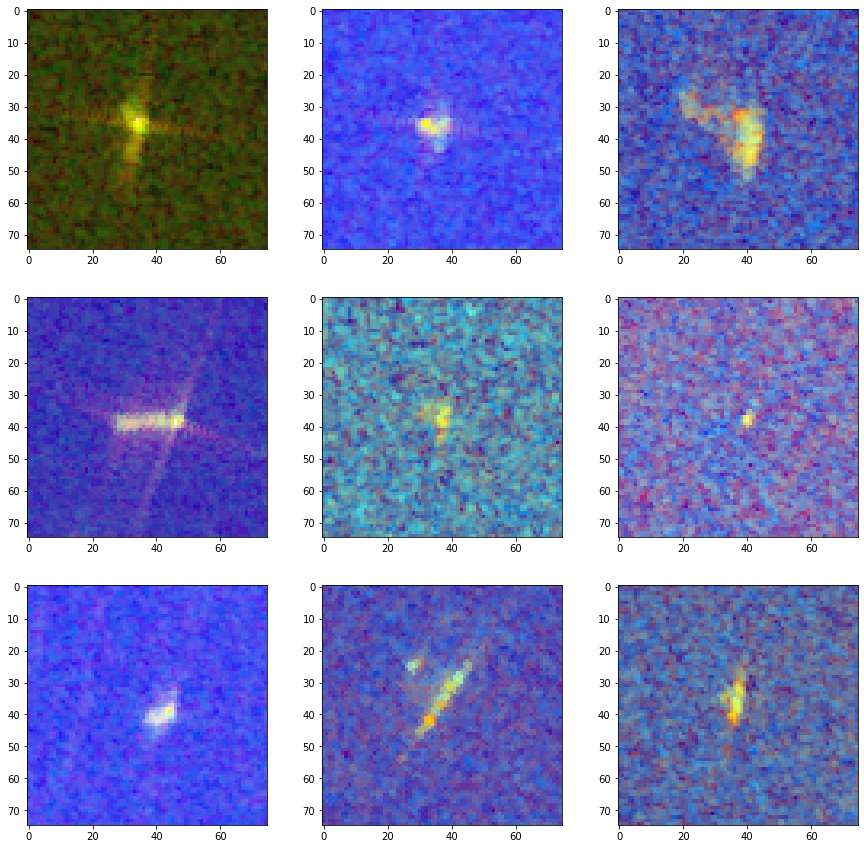

In [34]:
fig = plt.figure(200, figsize =(15, 15))

random_indicies = np.random.choice(range(len(X_images)), 9, False)
subset = X_images[random_indicies]

for i in range(9):
    ax = fig.add_subplot(3,3, i+1)
    ax.imshow(subset[i])
plt.show()

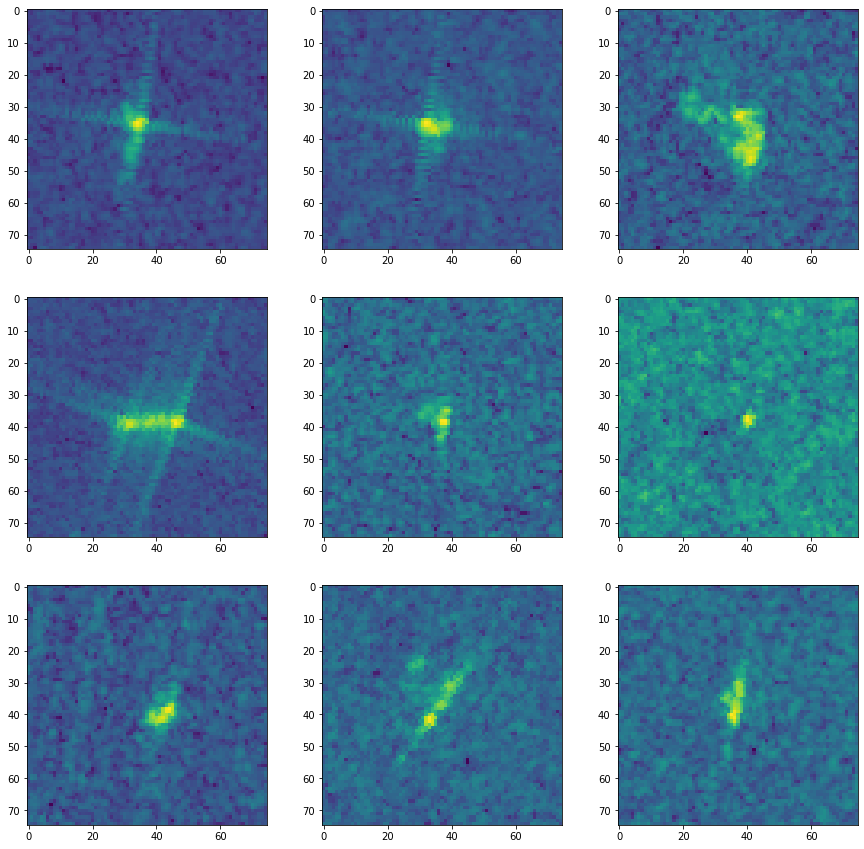

In [35]:
fig = plt.figure(202, figsize = (15, 15))

band_1_x = train['band_1'].values
subset = np.asarray(band_1_x)[random_indicies]
subset = np.asarray([np.asarray(item).reshape(75, 75) for item in subset])

for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(subset[i])
    
plt.show()

/var/folders/f5/y2439bls50z1n9fr018yc9q40000gn/T/ipykernel_50384/2251592410.py:19: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return np.asarray([denoise_tv_chambolle(item, weight = weight, multichannel = multichannel) for item in X])


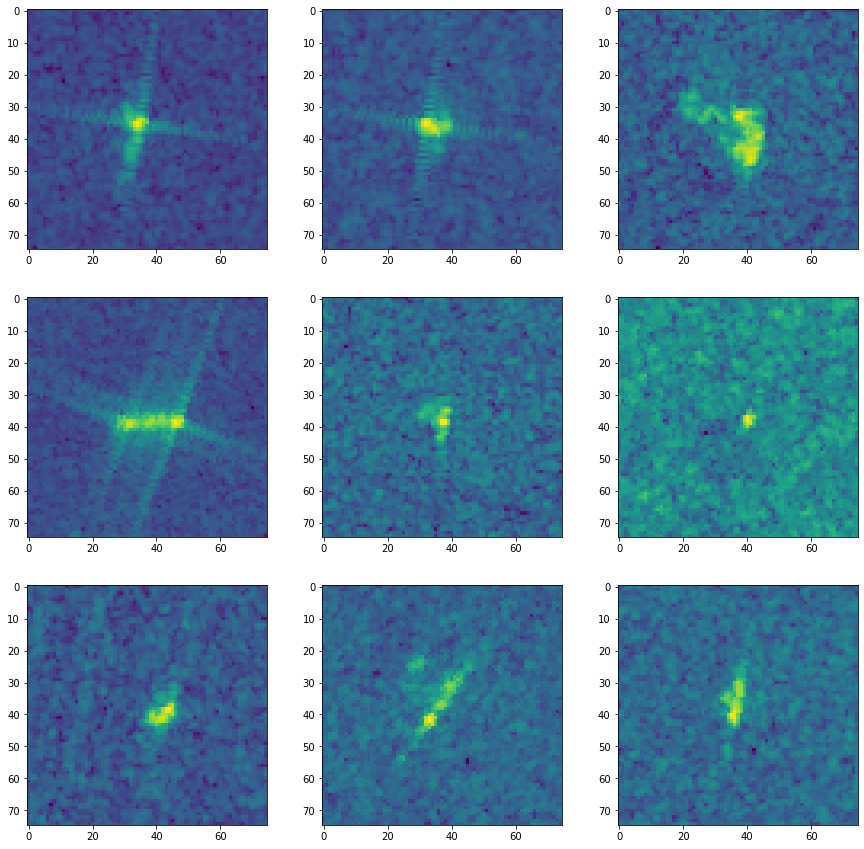

In [36]:
fig = plt.figure(202, figsize = (15, 15))

subset = np.asarray(band_1_x)[random_indicies]
subset = denoise(np.asarray([np.asarray(item).reshape(75, 75) for item in subset]), 0.05, False)

for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(subset[i])
    
plt.show()

/var/folders/f5/y2439bls50z1n9fr018yc9q40000gn/T/ipykernel_50384/2251592410.py:19: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return np.asarray([denoise_tv_chambolle(item, weight = weight, multichannel = multichannel) for item in X])


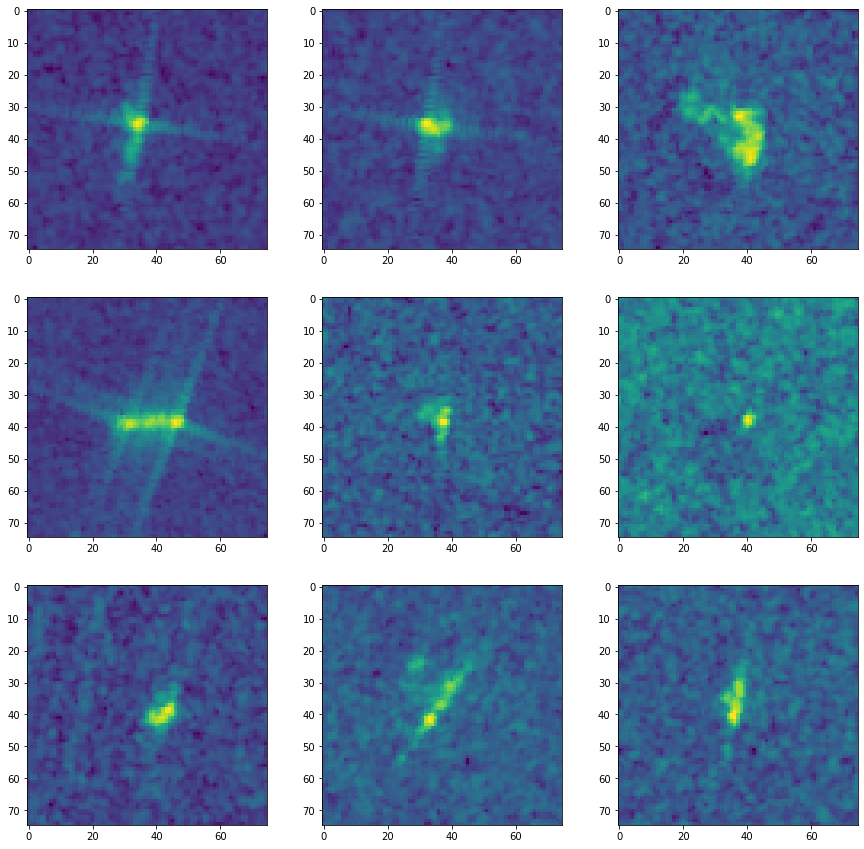

In [37]:
fig = plt.figure(202, figsize = (15, 15))

subset = np.asarray(band_1_x)[random_indicies]
subset = smooth(denoise(np.asarray(
    [np.asarray(item).reshape(75, 75) for item in subset]), 0.05, False), 0.5)

for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(subset[i])
    
plt.show()

**A few words about model**

모델은 3개의 Convnet으로 구성된다. 두 개의 기본적인 네트워크와 한 개의 네트워크가 결합하였다.<br>

이 아이디어는 서로 다른 두 데이터 속성(image & text etc)을 두 개의 네트워크를 통해 학습한 뒤 학습한 레이어를 조합하여 공통 네트워크로 만든 뒤 학습시크는 것이다.

이러한 구조는 처음 언급한 노트에서 가져온 것이다.

학습을 위해 3개의 데이터셋, 1개의 네트워크에서 keras val split을 통해 모델 선택을 했다.

In [60]:
def get_model_notebook(lr, decay, channels, relu_type = 'relu'):
    # angle variable defines if we should use angle parameter or ignore it
    input_1 = Input(shape = (75, 75, channels)) 
    
    fcnn = Conv2D(32, kernel_size = (3, 3), activation = relu_type)(
        BatchNormalization()(input_1))
    fcnn = MaxPooling2D((3, 3))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(64, kernel_size = (3, 3), activation = relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides = (2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(128, kernel_size = (3, 3), activation = relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides = (2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(128, kernel_size = (3, 3), activation = relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides = (2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = BatchNormalization()(fcnn)
    fcnn = Flatten()(fcnn)
    local_input = input_1
    partial_model = Model(input_1, fcnn)
    dense = Dropout(0.2)(fcnn)
    dense = Dense(256, activation = relu_type)(dense)
    dense = Dropout(0.2)(dense)
    dense = Dense(128, activation = relu_type)(dense)
    dense = Dropout(0.2)(dense)
    dense = Dense(64, activation = relu_type)(dense)
    dense = Dropout(0.2)(dense)
    # For some reason i've decided not to normalize angle data
    output = Dense(1, activation = 'sigmoid')(dense)
    model = Model(local_input, output)
    optimizer = Adam(lr = lr, decay = decay)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model, partial_model    

In [86]:
def combined_model(m_b, m_img, lr, decay):
    input_b = Input(shape = (75, 75, 3))
    input_img = Input(shape = (75, 75, 3))
    
    # I've never tested non-trainable source models tho
    # for layer in m_b.layers:
    #     layer.trainable = False
    # for layer in m_img.layers:
    #     layer.trainable = False
    
    m1 = m_b(input_b)
    m2 = m_img(input_img)
    
    # So, combine models and train perceptron based on that
    # The interesting idea is to use XGB for this task, but i actually hate this method
    
    common = Concatenate()([m1, m2])
    common = BatchNormalization()(common)
    common = Dropout(0.3)(common)
    common = Dense(1024, activation = 'relu')(common)
    common = Dropout(0.3)(common)
    common = Dense(512, activation = 'relu')(common)
    common = Dropout(0.3)(common)
    output = Dense(1, activation = 'sigmoid')(common)
    model = Model([input_b, input_img], output)
    optimizer = Adam(lr = lr, beta_1 = 0.9, beta_2 = 0.999, epsilon=1e-08, decay = decay)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

In [89]:
def gen_flow_multi_inputs(I1, I2, y, batch_size):
    gen1 = ImageDataGenerator(horizontal_flip = True,
                              vertical_flip = True,
                              width_shift_range = 0.,
                              height_shift_range = 0.,
                              channel_shift_range = 0.,
                              zoom_range = 0.2,
                              rotation_range = 10)
    gen2 = ImageDataGenerator(horizontal_flip=True,
                              vertical_flip=True,
                              width_shift_range=0.,
                              height_shift_range=0.,
                              channel_shift_range=0,
                              zoom_range=0.2,
                              rotation_range=10) 
    genI1 = gen1.flow(I1, y, batch_size = batch_size, seed = 57, shuffle = False)
    genI2 = gen1.flow(I1, I2, batch_size = batch_size, seed = 57, shuffle = False)
    while True:
        I1i = genI1.next()
        I2i = genI2.next()
        # print I1i[0].shape
        np.testing.assert_array_equal(I2i[0], I1i[0])
        
        yield [I1i[0], I2i[1]], I1i[1]
    

In [73]:
def train_model(model, batch_size, epochs, checkpoint_name, X_train, y_train, val_data, verbose = 2):
    callbacks = [ModelCheckpoint(checkpoint_name, save_best_only = True, moniter = 'val_loss')]
    datagen = ImageDataGenerator(horizontal_flip = True,
                                 vertical_flip = True,
                                 width_shift_range = 0.,
                                 height_shift_range = 0.,
                                 channel_shift_range = 0.,
                                 zoom_range = 0.2,
                                 rotation_range = 10)
    x_test, y_test = val_data
    try:
        model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size), epochs = epochs,
                            steps_per_epoch = len(X_train)/batch_size,
                            validation_data = (x_test, y_test), verbose = 1,
                            callbacks = callbacks)
    except KeyboardInterrupt:
        if verbose > 0:
            print("Interrupted")
    if verbose > 0:
        print("Loading Model")
        
    model.load_weights(filepath = checkpoint_name)
    
    return model


In [74]:
# Train a particular model
def gen_model_weights(lr, decay, channels, relu, batch_size, epochs, path_name, data, verbose = 2):
    X_train, y_train, X_test, y_test, X_val, y_val = data
    model, partial_model = get_model_notebook(lr, decay, channels, relu)
    model = train_model(model, batch_size, epochs, path_name,
                        X_train, y_train, (X_test, y_test), verbose = verbose)
    
    if verbose > 0:
        loss_val, acc_val = model.evaluate(X_val, y_val,
                                           verbose = 0, batch_size = batch_size)
        loss_train, acc_train = model.evaluate(X_test, y_test,
                                               verbose = 0, batch_size = batch_size)
        
        print("Val/Train Loss :", str(loss_val) + '/' + str(loss_train), \
              "Val/Train Acc :", str(acc_val) + '/' + str(acc_train))
        
    return model, partial_model

In [77]:
# Train all 3 models
def train_models(dataset, lr, batch_size, max_epoch, verbose = 2, return_model = False):
    y_train, X_b, X_images = dataset
    y_train_full, y_val, \
    X_b_full, X_b_val, \
    X_images_full, X_images_val = train_test_split(y_train, X_b, X_images, random_state = 687, train_size = 0.9)
    
    y_train, y_test, \
    X_b_train, X_b_test, \
    X_images_train, X_images_test = train_test_split(y_train_full, X_b_full, X_images_full, random_state = 576,
                                                     train_size = 0.85)
    
    if train_b:
        if verbose > 0:
            print("Training bandwidth network")
        data_b1 = (X_b_train, y_train, X_b_test, y_test, X_b_val, y_val)
        
        model_b, model_b_cut = gen_model_weights(lr, 1e-6, 3, 'relu', batch_size, max_epoch, 'model_b',
                                                 data_b1, verbose = verbose)
    
    if train_img:
        if verbose > 0:
            print("Training image network")
        data_images = (X_images_train, y_train, X_images_test, y_test, X_images_val, y_val)
        
        model_images, model_images_cut = gen_model_weights(lr, 1e-6, 3, 'relu', batch_size, max_epoch, 'model_img',
                                                 data_images, verbose = verbose)

    if train_total:
        common_model = combined_model(model_b_cut, model_images_cut, lr/2, 1e-7)
        common_x_train = [X_b_full, X_images_full]
        common_y_train = y_train_full
        common_x_val = [X_b_val, X_images_val]
        common_y_val = y_val
        
        if verbose > 0:
            print("Training common network")
        
        callbacks = [ModelCheckpoint('common', save_best_only = True, moniter = 'val_loss')]
        
        try:
            common_model.fit_generator(gen_flow_multi_inputs(X_b_full, X_images_full, y_train_full, batch_size),
                                         epochs=30,
                                  steps_per_epoch=len(X_b_full) / batch_size,
                                  validation_data=(common_x_val, common_y_val), verbose=1,
                                  callbacks=callbacks)
        except KeyboardInterrupt:
            pass
        common_model.load_weights(filepath='common')
        loss_val, acc_val = common_model.evaluate(common_x_val, common_y_val,
                                           verbose=0, batch_size=batch_size)
        loss_train, acc_train = common_model.evaluate(common_x_train, common_y_train,
                                                  verbose=0, batch_size=batch_size)
        if verbose > 0:
            print('Loss:', loss_val, 'Acc:', acc_val)
    if return_model:
        return common_model
    else:
        return (loss_train, acc_train), (loss_val, acc_val)

        

학습에 사용하는 모델 매개변수는 모든 데이터를 처리하기 충분한 계산 능력을 가지고 있다고 가정한다.

??? 여기서 중요한 것은 3세트를 저장하는 것입니다. 검증 세트를 기반으로 모델을 선택하는 경우 검증 세트의 잘못된 관측을 초래하고 최종 평가 점수에 영향을 미치기 때문에 최종 성능에 영향을 미치기 때문입니다.

In [90]:
# Best parameters i got are
# epochs : 250
# learning rate : 8e-5
# batch size : 32
common_model = train_models((y_train, X_b, X_images), 7e-04, 32, 50, 1, return_model=True)

Training bandwidth network
Epoch 1/50


/var/folders/f5/y2439bls50z1n9fr018yc9q40000gn/T/ipykernel_50384/981968737.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size), epochs = epochs,
2022-11-10 15:21:30.261039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


39/38 [==============================] - ETA: 0s - loss: 0.6175 - accuracy: 0.6044

2022-11-10 15:21:31.742316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: model_b/assets
38/38 [==============================] - 3s 68ms/step - loss: 0.6175 - accuracy: 0.6044 - val_loss: 1.2308 - val_accuracy: 0.5253
Epoch 2/50
38/38 [==============================] - 2s 49ms/step - loss: 0.5913 - accuracy: 0.6582 - val_loss: 0.9486 - val_accuracy: 0.5253
Epoch 3/50
38/38 [==============================] - 2s 51ms/step - loss: 0.5729 - accuracy: 0.6778 - val_loss: 0.8554 - val_accuracy: 0.5438
Epoch 4/50
38/38 [==============================] - 2s 46ms/step - loss: 0.5830 - accuracy: 0.6680 - val_loss: 0.6554 - val_accuracy: 0.6544
Epoch 5/50
38/38 [==============================] - 1s 23ms/step - loss: 0.5779 - accuracy: 0.6672 - val_loss: 0.6568 - val_accuracy: 0.5714
Epoch 6/50
38/38 [==============================] - 1s 23ms/step - loss: 0.5531 - accuracy: 0.6884 - val_loss: 0.6596 - val_accuracy: 0.5576
Epoch 7/50
38/38 [==============================] - 1s 23ms/step - loss: 0.5248 - accuracy: 0.7178 - val_loss: 0.69

38/38 [==============================] - 2s 46ms/step - loss: 0.3059 - accuracy: 0.8605 - val_loss: 0.3308 - val_accuracy: 0.8848
Epoch 35/50
38/38 [==============================] - 1s 25ms/step - loss: 0.2773 - accuracy: 0.8785 - val_loss: 0.3453 - val_accuracy: 0.8479
Epoch 36/50
38/38 [==============================] - 1s 22ms/step - loss: 0.3078 - accuracy: 0.8573 - val_loss: 0.3562 - val_accuracy: 0.8341
Epoch 37/50
38/38 [==============================] - 1s 24ms/step - loss: 0.2961 - accuracy: 0.8654 - val_loss: 0.3503 - val_accuracy: 0.8571
Epoch 38/50
38/38 [==============================] - 1s 22ms/step - loss: 0.3112 - accuracy: 0.8597 - val_loss: 0.3685 - val_accuracy: 0.8479
Epoch 39/50
38/38 [==============================] - 1s 23ms/step - loss: 0.2965 - accuracy: 0.8654 - val_loss: 0.3762 - val_accuracy: 0.8387
Epoch 40/50
38/38 [==============================] - 1s 22ms/step - loss: 0.2958 - accuracy: 0.8638 - val_loss: 0.4044 - val_accuracy: 0.8203
Epoch 41/50
38/38 

2022-11-10 15:22:26.858207: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open model_b: FAILED_PRECONDITION: model_b; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


Epoch 1/50


/Users/seosang-u/miniforge3/envs/tf25/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/var/folders/f5/y2439bls50z1n9fr018yc9q40000gn/T/ipykernel_50384/981968737.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size), epochs = epochs,
2022-11-10 15:22:27.530194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


38/38 [============================>.] - ETA: 0s - loss: 0.6176 - accuracy: 0.6457

2022-11-10 15:22:28.899174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: model_img/assets
38/38 [==============================] - 3s 53ms/step - loss: 0.6150 - accuracy: 0.6468 - val_loss: 0.6926 - val_accuracy: 0.5576
Epoch 2/50
38/38 [==============================] - 1s 25ms/step - loss: 0.5291 - accuracy: 0.7374 - val_loss: 0.6957 - val_accuracy: 0.4977
Epoch 3/50
38/38 [==============================] - 1s 22ms/step - loss: 0.4785 - accuracy: 0.7700 - val_loss: 0.7180 - val_accuracy: 0.5300
Epoch 4/50
38/38 [==============================] - 2s 48ms/step - loss: 0.4534 - accuracy: 0.7724 - val_loss: 0.6892 - val_accuracy: 0.5622
Epoch 5/50
38/38 [==============================] - 2s 46ms/step - loss: 0.4543 - accuracy: 0.7871 - val_loss: 0.6506 - val_accuracy: 0.6083
Epoch 6/50
38/38 [==============================] - 1s 23ms/step - loss: 0.4322 - accuracy: 0.7855 - val_loss: 0.6957 - val_accuracy: 0.5484
Epoch 7/50
38/38 [==============================] - 1s 24ms/step - loss: 0.4225 - accuracy: 0.7969 - val_loss: 0.

38/38 [==============================] - 1s 24ms/step - loss: 0.2923 - accuracy: 0.8638 - val_loss: 0.3244 - val_accuracy: 0.8802
Epoch 47/50
38/38 [==============================] - 1s 23ms/step - loss: 0.2740 - accuracy: 0.8785 - val_loss: 0.3657 - val_accuracy: 0.8295
Epoch 48/50
38/38 [==============================] - 1s 22ms/step - loss: 0.2813 - accuracy: 0.8695 - val_loss: 0.3790 - val_accuracy: 0.8295
Epoch 49/50
38/38 [==============================] - 1s 22ms/step - loss: 0.2730 - accuracy: 0.8809 - val_loss: 0.4507 - val_accuracy: 0.8157
Epoch 50/50
38/38 [==============================] - 1s 25ms/step - loss: 0.2967 - accuracy: 0.8630 - val_loss: 0.3493 - val_accuracy: 0.8479
Loading Model
Val/Train Loss : 0.28701305389404297/0.30590885877609253 Val/Train Acc : 0.8695652484893799/0.8755760192871094


2022-11-10 15:23:26.571244: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open model_img: FAILED_PRECONDITION: model_img; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


Training common network
Epoch 1/30


/Users/seosang-u/miniforge3/envs/tf25/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/var/folders/f5/y2439bls50z1n9fr018yc9q40000gn/T/ipykernel_50384/1408676785.py:42: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  common_model.fit_generator(gen_flow_multi_inputs(X_b_full, X_images_full, y_train_full, batch_size),
2022-11-10 15:23:27.182347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


46/45 [==============================] - ETA: 0s - loss: 0.3594 - accuracy: 0.8565

2022-11-10 15:23:32.208160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: common/assets
45/45 [==============================] - 7s 137ms/step - loss: 0.3594 - accuracy: 0.8565 - val_loss: 0.2406 - val_accuracy: 0.8882
Epoch 2/30
45/45 [==============================] - 4s 89ms/step - loss: 0.2109 - accuracy: 0.9092 - val_loss: 0.2263 - val_accuracy: 0.8820
Epoch 3/30
45/45 [==============================] - 4s 87ms/step - loss: 0.1352 - accuracy: 0.9494 - val_loss: 0.2250 - val_accuracy: 0.8882
Epoch 4/30
45/45 [==============================] - 2s 46ms/step - loss: 0.0884 - accuracy: 0.9660 - val_loss: 0.2267 - val_accuracy: 0.9006
Epoch 5/30
45/45 [==============================] - 2s 47ms/step - loss: 0.0494 - accuracy: 0.9889 - val_loss: 0.3456 - val_accuracy: 0.8696
Epoch 6/30
45/45 [==============================] - 2s 46ms/step - loss: 0.0250 - accuracy: 0.9945 - val_loss: 0.6155 - val_accuracy: 0.8758
Epoch 7/30
45/45 [==============================] - 2s 47ms/step - loss: 0.0182 - accuracy: 0.9938 - val_loss: 0.55

2022-11-10 15:24:40.063927: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open common: FAILED_PRECONDITION: common; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


Loss: 0.22503425180912018 Acc: 0.8881987929344177


In [92]:
# if predict_submission:
#     print('Reading test dataset')
#     test = pd.read_json("../input/test.json")
#     y_fin, X_fin_b, X_fin_img = create_dataset(test, False)
#     print('Predicting')
#     prediction = common_model.predict([X_fin_b, X_fin_img], verbose=1, batch_size=32)
#     print('Submitting')
#     submission = pd.DataFrame({'id': test["id"], 'is_iceberg': prediction.reshape((prediction.shape[0]))})

#     submission.to_csv("./submission.csv", index=False)
#     print('Done')


--------

### 1. 데이터셋 설명 

Drifting icebergs 감지<br>

멀리서 감지된 타겟이 배인지 빙산인지 자동으로 식별하는 알고리즘을 구축


**id** - 이미지의 id<br>
**band_1, band_2** - 병합된 이미지 데이터. 각 밴드의 목록에는 75x75 픽셀 값이 있으므로 목록에는 5625개의 요소가 있습니다. 이 값은 물리적 의미가 있기 때문에 이미지 파일에서 일반적인 음이 아닌 정수가 아닙니다. 이 값은 단위가 dB 인 부동 소수점 숫자입니다 . 대역 1 및 대역 2는 특정 입사각에서 서로 다른 편광에서 생성된 레이더 후방 산란을 특징으로 하는 신호입니다. 편광은 HH(수평 전송/수신) 및 HV(수평 전송 및 수직 수신)에 해당합니다. 위성 이미지에 대한 더 많은 배경 정보는 여기 에서 찾을 수 있습니다 .<br>
**inc_angle** - 이미지가 촬영된 입사각. 이 필드에는 "na"로 표시된 누락된 데이터가 있으며 "na" 입사각이 있는 이미지는 누출을 방지하기 위해 모두 훈련 데이터에 있습니다.<br>
**is_iceberg** - 대상 변수로, 빙산이면 1로 설정하고 선박이면 0으로 설정합니다.


### 2. 분석 기법 등 이번 노트에서 쓰인 방법론

CNN

-----

#### 1. 공부한 내용
 → 다 알고 있는 내용이다..

#### 2. 어려웠던 부분
 → 없음
 
#### 3. 느낀점 및 좋던 부분
 → 해당 노트는 전처리에 대한 영역이 거의 존재하지 않고 오직 stacking으로만 분석을 하다보니 아쉽다.
 
#### 4. 라이브러리 사용법
 → 
 
#### 5. 해당 커널의 특징(다른 커널과의 차별점)
 → 성능을 높이기 위해 stacking만을 사용하였고 그 밖에 다른 방법은 딱히 사용하지 않았다.
 
#### 6. 추후 공부 및 정리할 내용
 → catboost에 대한 내용